## Application: Wage and Education

#### Variables:

+ work - participation in 1975 ?
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
from numpy.linalg import lstsq
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'
# ignore warnings
import warnings 
warnings.simplefilter('ignore')
# bokeh
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

#### Data retrieval

`read_csv` creates a Pandas dataframe by retrieving data from a CSV file.

```Python
    read_csv(file name, option 1, option 2, ...)
```

`index_col=0` implies that the first column of the CSV file is used as the index of observations.


In [2]:
data = pd.read_csv('Mroz.csv', index_col=0)
wage = data['wagew'].values
educ = data['educw'].values
y = wage[wage > 0]
x = educ[wage > 0] - 12
ols_b = lstsq(np.vstack((np.ones(x.size), x)).T, y, rcond=None)[0]

In [3]:
x_range = np.array([1.1*np.min(x), 1.1*np.max(x)])
y_range = np.array([ols_b[0] + ols_b[1]*x_range[0], ols_b[0] + ols_b[1]*x_range[1]])
p = figure(plot_width=400, plot_height=300, toolbar_location=None, title='Relationship Between Wage And Years Of Schooling')
p.line(x_range, y_range, line_color='navy', line_width=2, legend_label='Regression line (OLS)')
p.cross(x, y, color='firebrick', size=8, legend_label='Observations')
p.xaxis.axis_label = 'Years of schooling after high school'
p.yaxis.axis_label = 'Hourly wage'
p.legend.location = 'top_left'
p.legend.click_policy = 'hide'
p.legend.border_line_color = p.xgrid.grid_line_color = p.ygrid.grid_line_color = p.outline_line_color = None
show(p)

In [4]:
mu_a = 0.0
mu_b = 0.0
omega_a = 10.0
omega_b = 10.0
nu0 = 0.02
lam0 = 0.02

In [5]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=mu_a, sigma=omega_a)
    b = pm.Normal('b', mu=mu_b, sigma=omega_b)
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y)

In [6]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.


In [7]:
post_stats = pm.summary(trace)
post_stats.index = ['constant', 'education', '$\\sigma^2$']
display(post_stats)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
constant,3.913,0.096,3.732,4.094,0.001,0.000,21879.0,21879.0,21853.0,14775.0,1.0
education,0.395,0.041,0.316,0.471,0.000,0.000,22909.0,22466.0,22910.0,14267.0,1.0
$\sigma^2$,2.812,0.223,2.403,3.228,0.001,0.001,25949.0,25648.0,25919.0,14589.0,1.0


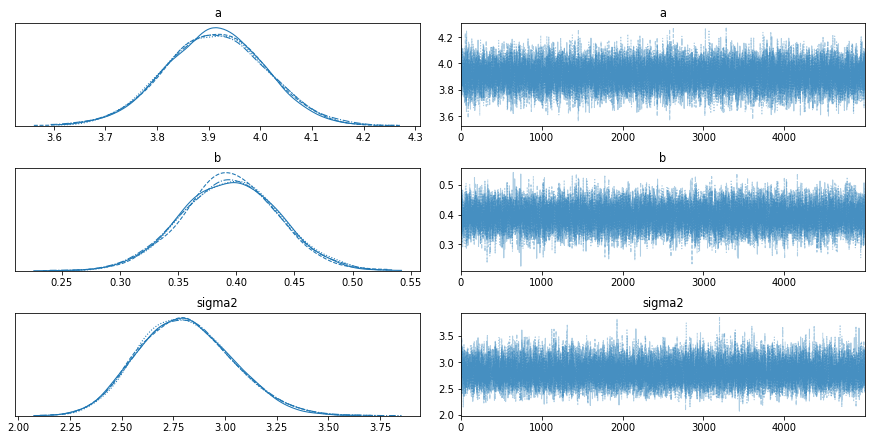

In [8]:
pm.traceplot(trace)
plt.show()

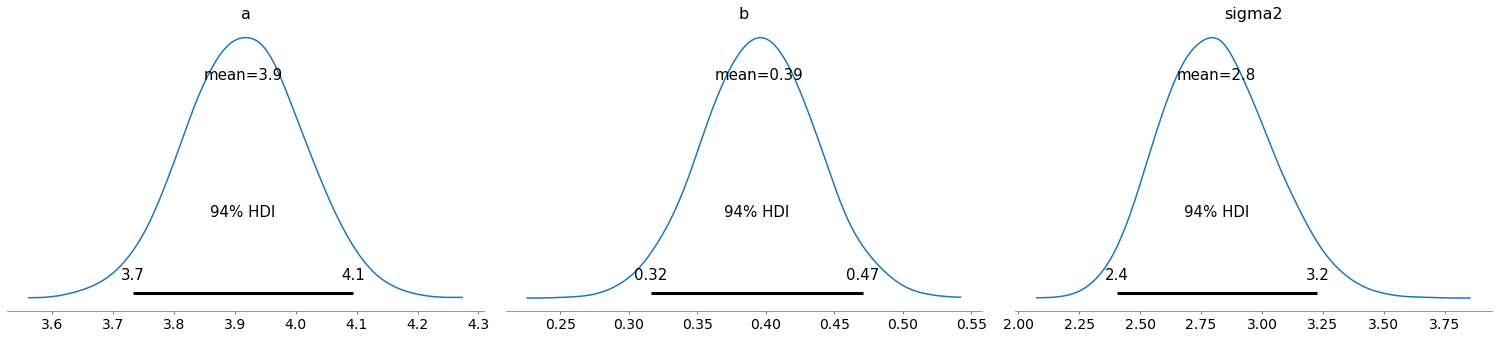

In [9]:
pm.plot_posterior(trace, kind='kde', point_estimate='mean')
plt.show()